In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [13]:
# Image completion
import os
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists


In [14]:
# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


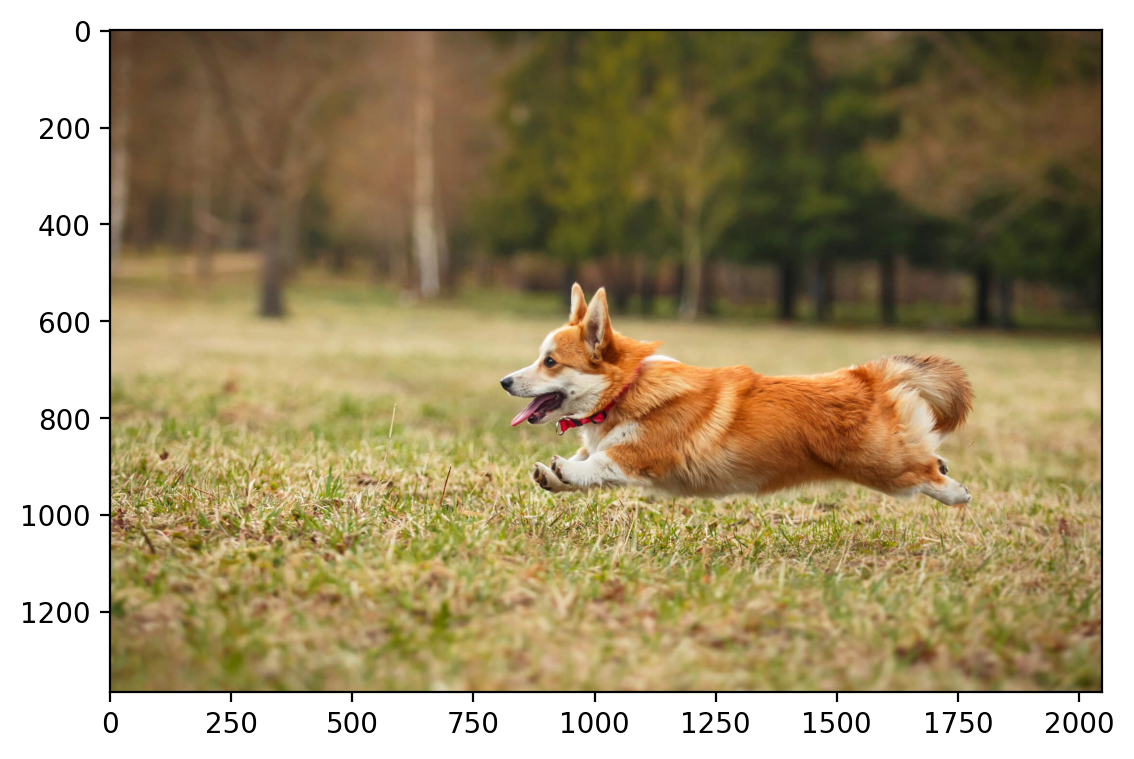

In [15]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

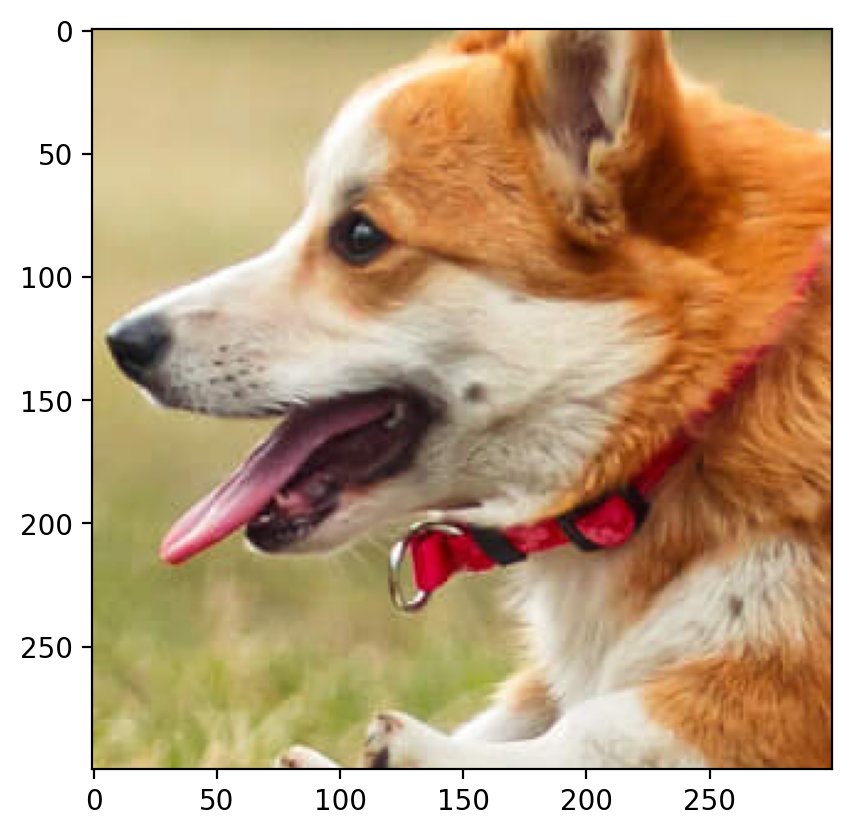

In [16]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img
from sklearn.preprocessing import MinMaxScaler
MinMaxScaler()
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)
img_scaled
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 300, 300)
crop.shape
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [17]:
original_image = crop.clone()

In [18]:
def create_missing_patch_with_nan(img, start_h, start_w, patch_size):
    img_copy = img.clone()

    # Check if the image is grayscale or color
    if len(img_copy.shape) == 2:  # Grayscale image
        img_copy[start_h:start_h+patch_size, start_w:start_w+patch_size] = float('nan')
    elif len(img_copy.shape) == 3:  # Color image
        img_copy[:, start_h:start_h+patch_size, start_w:start_w+patch_size] = float('nan')

    return img_copy

In [19]:
def fill_nans_with_neighbors(A):
    mask = ~torch.isnan(A)

    for i in range(A.shape[1]):
        mask_rows = mask[:, i]
        unknown_rows = ~mask_rows

        if unknown_rows.any():
            # Forward fill using the previous (i-1th) row
            A[unknown_rows, i] = A[unknown_rows, i - 1].clone().detach()

    return A

In [20]:
def factorize(A, k, device=torch.device("cpu")):
    """Factorize the matrix D into A and B using Alternating Least Squares (ALS)"""
    A = A.to(device)

    # Fill NaN values with values from the previous column
    A = fill_nans_with_neighbors(A)

    # Randomly initialize A and B for each channel with the same dtype as A
    dtype = A.dtype
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device, dtype=dtype)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device, dtype=dtype)

    for i in range(100):    
        for j in range(H.shape[1]):
            mask_rows = ~torch.isnan(A[:, j])
            h_j = torch.linalg.lstsq(W[mask_rows], A[:, j][mask_rows]).solution
            with torch.no_grad():
                H[:, j] = h_j

        A_ = A.t()
        W_ = W.t()
        H_ = H.t()
        for j in range(W_.shape[1]):
            mask_rows = ~torch.isnan(A_[:, j])
            w_j = torch.linalg.lstsq(H_[mask_rows], A_[:, j][mask_rows]).solution
            with torch.no_grad():
                W_[:, j] = w_j

        W = W_.t()
        if i % 100 == 0:
            print(f"epoch {i}")

    # Compute the final loss
    diff_matrix = torch.mm(W, H) - A
    loss = torch.norm(diff_matrix)
    return W, H, loss


In [21]:
Errors={'Type':[],'RMSE': [],'Peak SNR':[]}

In [22]:
def plot_reconstructed_and_original_image(original_img, img_with_missing_patch, finalImg, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1,1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax2 = plt.subplot(gs[2])

    ax0.imshow(rearrange(original_img, 'c h w -> h w c').cpu().detach().numpy())
    #ax0.imshow(original_image.reshape(300,300,3).cpu().numpy())
    ax0.set_title("Original Image")


    ax1.imshow(rearrange(img_with_missing_patch, 'c h w -> h w c').cpu().detach().numpy())
    #ax1.imshow(img_with_missing_patch.reshape(300,300,3).cpu().numpy())
    ax1.set_title("Image with missing patch")
    #ax2.imshow(finalImg.reshape(300,300,3).cpu().numpy())
    ax2.imshow(rearrange(finalImg, 'c h w -> h w c').cpu().detach().numpy())
    ax2.set_title(f"Reconstructed Image")
    squared_error = torch.square(rearrange(finalImg, 'c h w -> h w c').cpu() - rearrange(original_img, 'c h w -> h w c').cpu())
    mse = torch.mean(squared_error)

    # Calculate the root mean squared error
    rmse = torch.sqrt(mse)

    # Calculate the peak signal value (assuming the vectors are in the range [0, 1])
    max_val = 1.0
    psnr = 10 * torch.log10(max_val / rmse)
    Errors["Type"].append(title)
    Errors["RMSE"].append(rmse.cpu().detach().numpy())
    Errors["Peak SNR"].append(psnr.cpu().detach().numpy())
    print(f"Type: {title} , RMSE: {rmse}, PSNR: {psnr} \n")

# Calculate the PSNR
    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

epoch 0
epoch 0
epoch 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Type: Reconstructed Image for Single Color (Patch Size 20) , RMSE: 0.009919388755088356, PSNR: 20.035150887804022 

epoch 0
epoch 0
epoch 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Type: Reconstructed Image for Single Color (Patch Size 30) , RMSE: 0.01125625721857165, PSNR: 19.486059913258014 

epoch 0
epoch 0
epoch 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Type: Reconstructed Image for Single Color (Patch Size 40) , RMSE: 0.012150696592509086, PSNR: 19.15398823496876 

epoch 0
epoch 0
epoch 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Type: Reconstructed Image for Single Color (Patch Size 60) , RMSE: 0.02362236243102176, PSNR: 16.266766715213546 

epoch 0
epoch 0
epoch 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Type: Reconstructed Image for Single Color (Patch Size 80) , RMSE: 0.048005694026652154, PSNR: 13.187072472558128 

ErrorDF:                                                  Type                  RMSE  \
0  Reconstructed Image for Single Color (Patch Si...  0.009919388755088356   
1  Reconstructed Image for Single Color (Patch Si...   0.01125625721857165   
2  Reconstructed Image for Single Color (Patch Si...  0.012150696592509086   
3  Reconstructed Image for Single Color (Patch Si...   0.02362236243102176   
4  Reconstructed Image for Single Color (Patch Si...  0.048005694026652154   

             Peak SNR  
0  20.035150887804022  
1  19.486059913258014  
2   19.15398823496876  
3  16.266766715213546  
4  13.187072472558128  


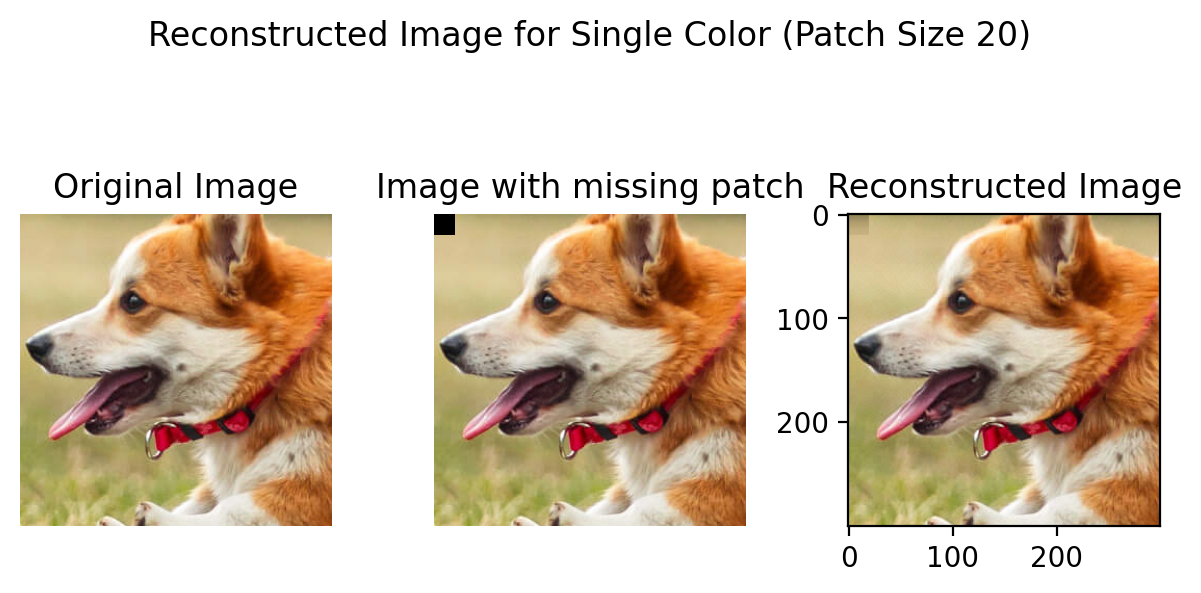

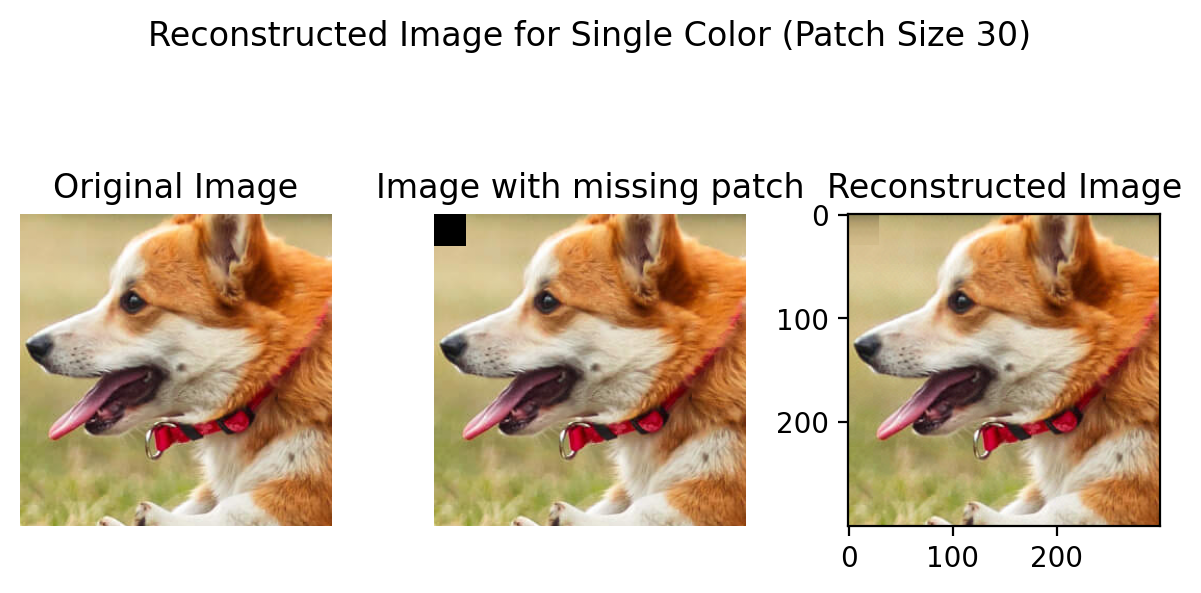

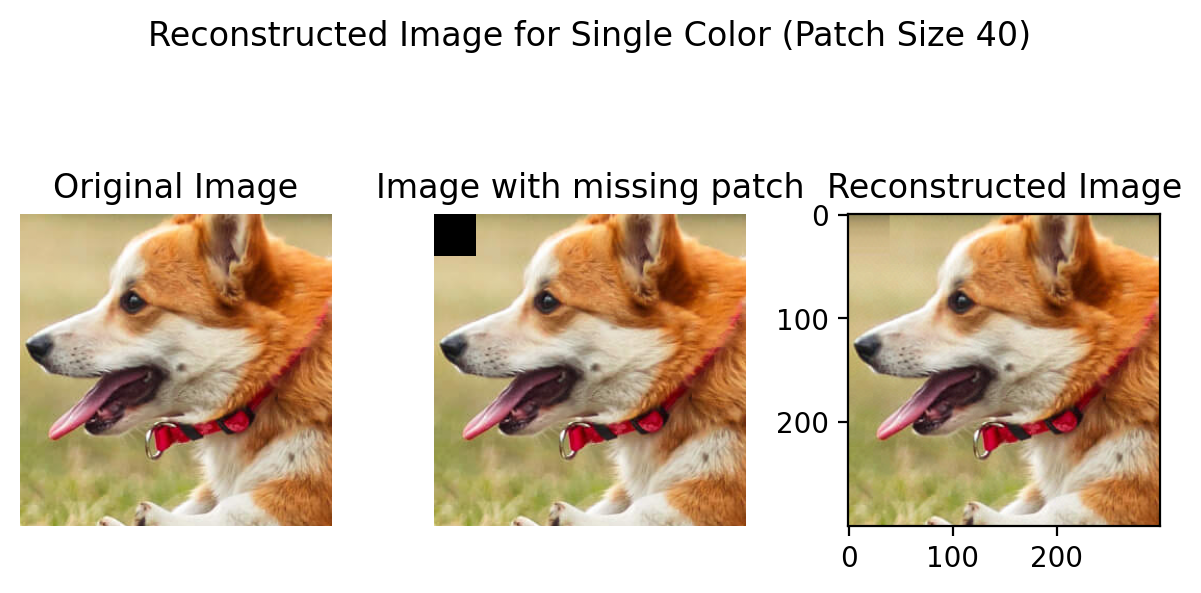

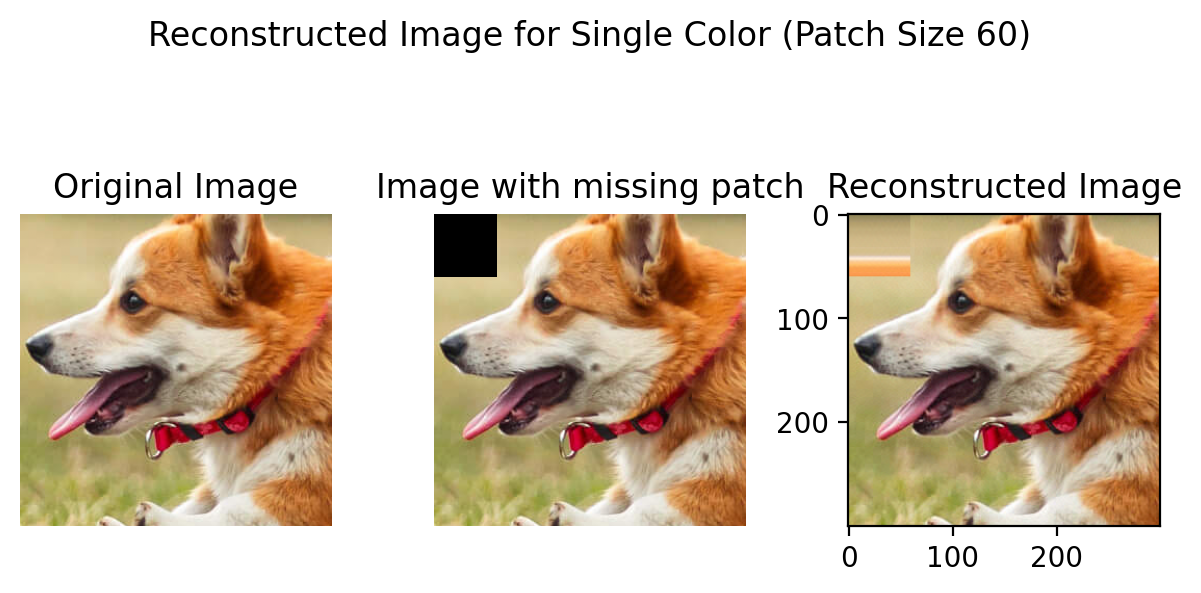

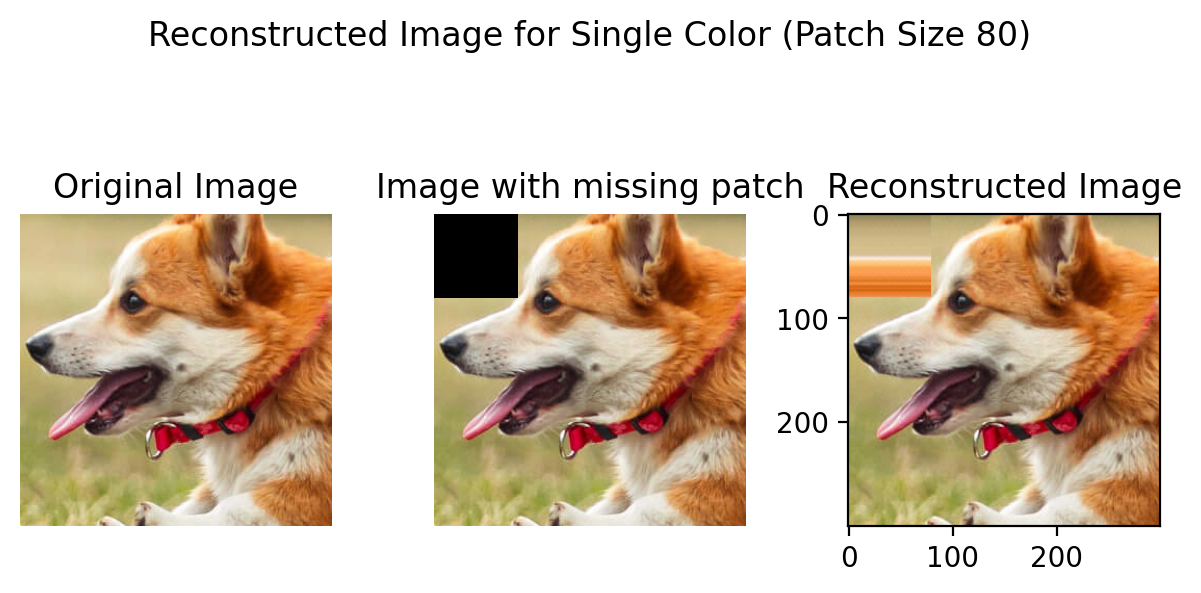

In [23]:
start_x = [0]
start_y = [0]
label = ["Single Color"]
patch_sizes = [20, 30, 40, 60, 80]  # Different patch sizes (N)

for patch_size in patch_sizes:
    for idx, i in enumerate(start_x):
        img_with_missing_patch = create_missing_patch_with_nan(crop, i, start_y[idx], patch_size)
        Wr, Hr, lossr = factorize(img_with_missing_patch[0], 100, device=device)
        Wg, Hg, lossg = factorize(img_with_missing_patch[1], 100, device=device)
        Wb, Hb, lossb = factorize(img_with_missing_patch[2], 100, device=device)
        
        finalImg = torch.Tensor(3, 300, 300)
        finalImg[0] = torch.mm(Wr, Hr)
        finalImg[1] = torch.mm(Wg, Hg)
        finalImg[2] = torch.mm(Wb, Hb)
        
        plot_reconstructed_and_original_image(crop, img_with_missing_patch, finalImg, title=f"Reconstructed Image for {label[idx]} (Patch Size {patch_size})")

# Assuming Errors and ErrorDF are defined globally or within the context of the code.
ErrorDF = pd.DataFrame(Errors)
ErrorDF.reset_index(drop=True, inplace=True)

print("ErrorDF: ", ErrorDF)